# Optimal Stopping of Fractional Brownian Motion Using Signature Methods

In this notebook, we are going to implement the two (primal) variants of the signature method for optimal stopping introduced in the book. 
We then benchmark these methods for the optimal stopping problem of a fractional Brownian motion with various Hurst parameters. Therefore, we will need the following `python` packages:

In [2]:
import numpy as np
import torch # install with: pip install pytorch
import iisignature # install with: pip install iisignature
import matplotlib
from matplotlib import pyplot as plt
import pickle # for saving and reading dictionaries
from IPython.display import display, clear_output, HTML # for displaying the HTML table
%run style.ipynb # configuration for the style of our plots

### Sampling of fractional Brownian motion

Since we are mainly interested in implementing and training the signature-stopping strategies, we have outsourced the code for sampling the fractional Brownian motion to the following file:

In [5]:
from fbm_sampling import time_augmented_fbm

If you are interested in learning more about this code, the exercise sheet [here](https://hagerpa.github.io/talks/excersize_sheet_sampling_of_fBm.pdf) walks you through the theory behind it step by step. 
Let's generate a few sample paths to have something to test our code with while implementing.


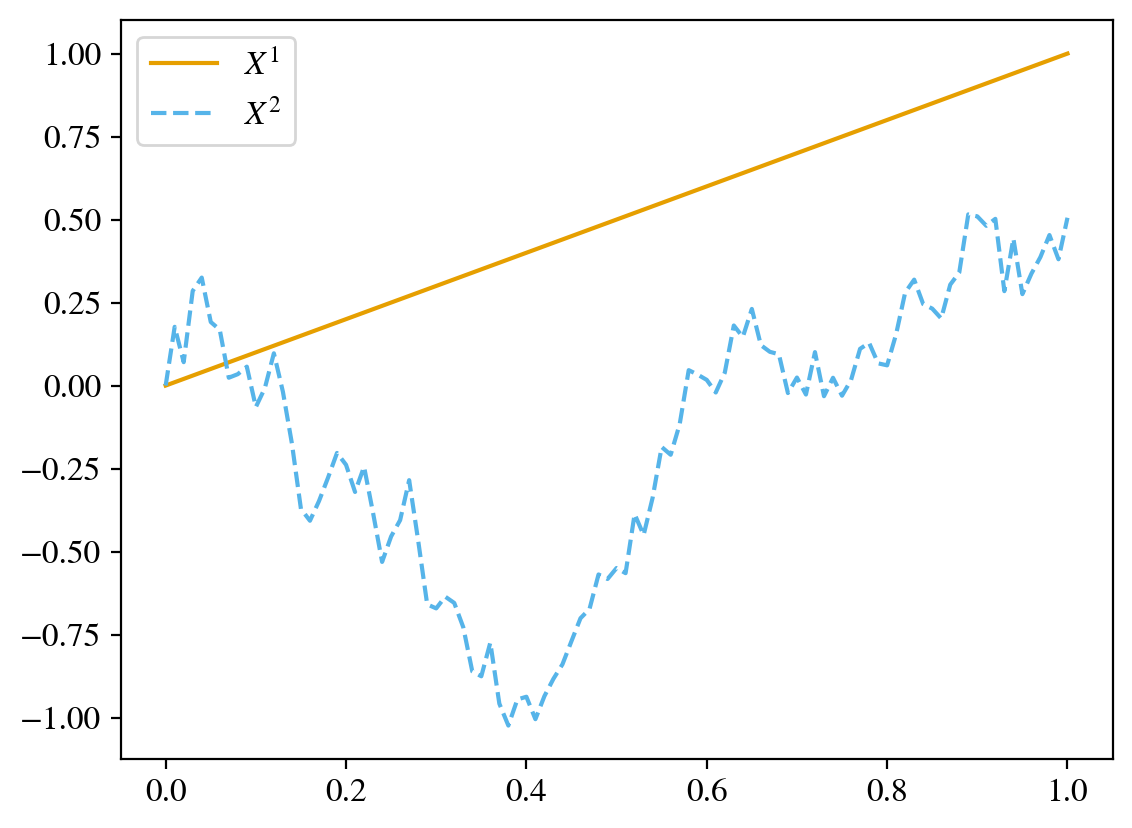

In [8]:
m = 64 # number of samples
n = 100 # number of time steps
T = 1.0 # time horizon
H = 0.5 # Hurst parameter of the fractional Brownian motion
X = time_augmented_fbm(H=H, T=T, time_steps=n, samples=m)

k = np.random.randint(m) # selecting a random sample
plt.plot(X[k,:,0], X[k,:,0], label = "$X^1$")
plt.plot(X[k,:,0], X[k,:,1], label = "$X^2$")
plt.legend();

Note that `X` is a numpy array of the shape `(m, n+1, d)`, where `m` is the number of samples, `n` is the number of time steps, and `d` is the dimension of the path. We will always use this convention in the following. In the above example, `d=2` since `X` constitutes sample paths of a time-augmented fractional Brownian motion $\hat{X} = (t, X_t)_{0 \le t \le T}$ on a finite time grid with `n=100` points. Moreover, `H=0.5`, hence, the samples actually correspond to a standard Brownian motion.

### Calculating the Signature

Next, let us calculate the signature of these sample paths using the `iisignature` package. Suppose we want to calculate the signature of $\hat{X}$ over the time interval $[0,T]$ for a given truncation level $I$, i.e., $\hat{\mathbb{X}}_{0,T}^{\le I}$. Given the sample paths `X` on the discrete time grid, we can only approximate the signature. The command `iisignature.sig` returns the signature of the linearly interpolated points of `X`:

In [66]:
I = 3 # truncation level
sig = iisignature.sig(X, I)
print(sig.shape)
print(sig[k])

(1024, 14)
[ 1.          0.38860533  0.5        -0.11370194  0.50230727  0.07550705
  0.16666667 -0.03972213 -0.03425769  0.06047562  0.26828248 -0.16513641
  0.18016785  0.00978081]


The array `sig` now contains the approximated signature for each of the sample paths as a vector of length `sig_dim = 1 + d + ... + d**I`. The components are ordered first by the tensor level and then lexicographically. Note that the dimension of the signature `sig_dim` can also be conveniently obtained with the command `iisig.siglength(d, I)`.

**NB-Exercise 1:** *Calculate the first two levels of the signature by approximating the corresponding iterated integrals using the piecewise linear interpolation of $X$. Then, verify your results with the code provided above.*

**Uncomment the code line below and run the cell twice (2x ctrl + enter) to see the solution.**

In [67]:
# %load solutions/exercise1.py

To implement the signature methods for optimal stopping, we will need the signature on increasing time intervals $(\hat{\mathbb{X}}_{0,t}^{\le I})_{0 \le t \le T}$.
The `iisignature.sigjoin` function allows us to efficiently calculate the approximated signature on an interval $[0, t_{i}]$, given the signature on a previous sub-interval $\hat{\mathbb{X}}_{0,{t_{i-1}}}^{\le I}$ and the path increment $X_{t_i} - X_{t_{i-1}}$. 
The following function calculates the signature on all consecutive time intervals of the grid.

In [68]:
def signature_process(X, I):
    m_, n_, d_ = X.shape
    sig_ = np.zeros((m_, n_, iisignature.siglength(d_, I)))
    sig_[:, 0, 0] = 1 # initialize signature with the idenity
    for i in range(1, n_):
        sig_[:, i, :] = iisignature.sigjoin(sig_[:, i-1, :], X[:, i] -  X[:, i-1], I)
    return sig_

Sig = signature_process(X, I)

The array `Sig` now contains the signature for each sample path on each subinterval $[0, t_i]$ of the grid. Therefore, it is of the shape `(m, n+1, sig_dim)`.

**NB-Exercise 2:** *Given the `Sig` array, plot the evolution of the* **area** *between the first and second component of the path, i.e., the evolution of* $$\frac{1}{2}\left(\int_0^\cdot X^1 dX^2 - \int_0^\cdot X^2 dX^1\right).$$

In [69]:
# %load solutions/exercise2.py

Having available functions for generating sample paths and calculating their signatures, we can now turn to the implementation of the signature methods for optimal stopping. We will first implement the method introduced in Section 3.1, based on the parametrization of the stopping times by signature stopping rules. After that, we are going to implement the Longstaff–Schwartz approach.

## Parametrized Signature Stopping Times 

### Implementing the Signature Stopping Rules

Since we intend to use a stochastic gradient descent method to optimize the parameters of our signature stopping rules, we will implement these using the `torch.nn.Module`. Let's start with the simpler case of linear signature stopping rules of the form $\theta_t = \langle \ell, \hat{\mathbb{X}}_{0,{t}}^{\le I}\rangle$. Essentially, we want the module to take an array of sample paths `X` and calculate the signature stopping rule $\theta_{t_i} = \langle \ell, \hat{\mathbb{X}}_{0,{t_i}}^{\le I}\rangle$ for every time point $t_i$ of the time grid, thus returning an array of the shape `(m, n+1)`. Since the step of calculating the signature for a given array `X` is an unparametric preprocessing step, already implemented in the function `signature_process`, it will be more convenient to assume that the module already takes the truncated signature process as an input. The module then essentially consists of applying a `torch.nn.Linear` layer to the input.

In [74]:
class LinearSignatureRule(torch.nn.Module):
    def __init__(self, d, I):
        """
        ReLU deep neural network
        :param d: dimension of the underlying paths
        :param I: truncation level
        """
        super(LinearSignatureRule, self).__init__()
        in_dim = iisignature.siglength(d, I)  # setting the input dimension of the module

        # defining the sequence of layers
        layers = [
            torch.nn.Linear(in_dim, 1, dtype=torch.float64, bias=False),  # linear layer with ouput dimension 1
            torch.nn.Flatten()  # flattening layer to reduce output from (m, n+1, 1) to (m, n+1)
        ]
        self.layers = torch.nn.Sequential(*layers) # concatenate the previously defined layers

    def forward(self, x):
        return self.layers(x)

Let's apply a randomly initialized linear strategy to see if the output dimensions are correct. You can run the following cell several times to observe different initializations.

Parameter containing:
tensor([[ 0.2207, -0.1841,  0.0406, -0.1274, -0.0930, -0.2644,  0.1565,  0.1474,
          0.0358, -0.0751,  0.1595, -0.0323, -0.0038, -0.2569]],
       dtype=torch.float64, requires_grad=True)
torch.Size([1024, 101])


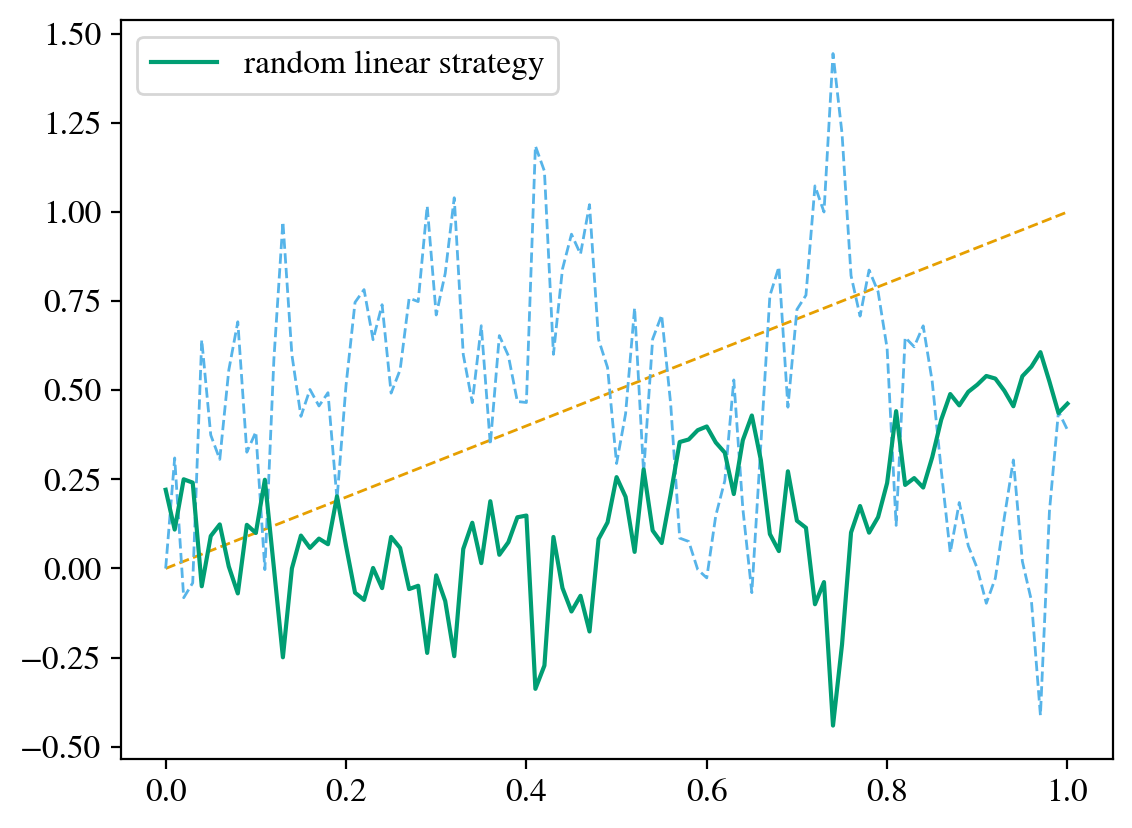

In [75]:
lin_strat = LinearSignatureRule(2, I)
print(lin_strat.layers[0].weight) # printing randomnly initialized weights

Sig_torch = torch.from_numpy(Sig) # parsing Sig numpy array to torch tensor
theta = lin_strat(Sig_torch) # applying the linear strategy
print(theta.shape) # printing shape of the output

plt.plot(X[k, :, 0], X[k, :, 0], linewidth=1, linestyle="dashed")
plt.plot(X[k, :, 0], X[k, :, 1], linewidth=1, linestyle="dashed")
plt.plot(X[k, :, 0], theta[k,:].detach().numpy(), label="random linear strategy", linestyle='solid')
plt.legend();

**NB-Exercise 3:** *By accessing the weights of the linear map through `lin_strat.layers[0].weight`, verify that the `LinearSignatureRule` really just takes a linear combination of the signature components with these weights.*

In [76]:
# %load solutions/exercise3.py

The implementation of the deep signature stopping rule is almost identical to the linear case, with the only difference being that we add more linear layers and activation functions between them.

In [77]:
class DeepSignatureRule(torch.nn.Module):
    def __init__(self, d, I, n_layers, n_neurons):
        """
        ReLU deep neural network
        :param d: dimension of the underlying paths
        :param I: truncation level
        :param n_layers: number of hidden layers
        :param n_neurons: number of neurons per hidden layer
        """
        super(DeepSignatureRule, self).__init__()
        in_dim = iisignature.siglength(d, I)  # setting the input dimension of the module

        # defining the sequence of layers
        dim_ = in_dim
        layers = []
        for _ in range(n_layers):
            layers += [torch.nn.Linear(dim_, n_neurons, dtype=torch.float64), torch.nn.ReLU()]
            dim_ = n_neurons
        
        layers += [
            torch.nn.Linear(dim_, 1, dtype=torch.float64),  # linear layer with ouput dimension 1
            torch.nn.Flatten()  # flattening layer to reduce output from (m, n+1, 1) to (m, n+1)
        ]
        self.layers = torch.nn.Sequential(*layers) # concatenate the previously defined layers

    def forward(self, x):
        return self.layers(x)

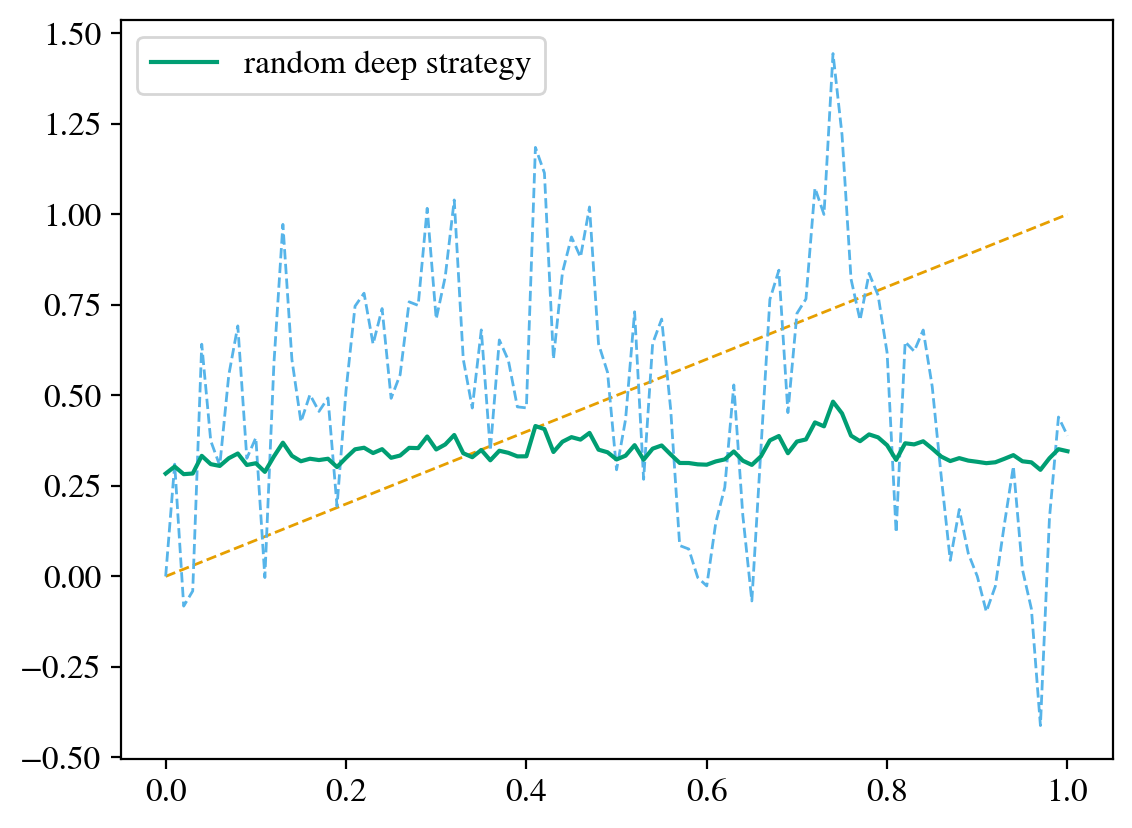

In [78]:
deep_strat = DeepSignatureRule(2, I, n_layers = 2, n_neurons = 10) # randomly initializing deep strategy

plt.plot(X[k, :, 0], X[k, :, 0], linewidth=1, linestyle="dashed")
plt.plot(X[k, :, 0], X[k, :, 1], linewidth=1, linestyle="dashed")
plt.plot(X[k, :, 0], deep_strat(Sig_torch)[k,:].detach().numpy(), label="random deep strategy", linestyle='solid')
plt.legend();

### Implementing the Loss-Function

Recall that using randomization, the expected payoff associated with a signature stopping rule $\theta$ can be expressed as $$\mathbb{E}\left[ Y_{\tau_{\theta}}\right] = \mathbb{E}\left[ Y_0 + \int_0^T \exp\left(-\int_0^t \theta(\widehat{\mathbb{X}}^{\le I}_{0,s})^2 \mathrm{d}s\right) \mathrm{d}Y_t\right], \tag{1}$$
where $Y$ is the payoff process. Note that in our specific example, the payoff process is the fractional Brownian motion itself, i.e., $Y = X$.
Since our aim is to *maximize* the above expectation, we can define the following loss associated with $\theta$
$$L(\theta; Y, X) := - \mathbb{E}\left[ \int_0^T \exp\left(-\int_0^t \theta(\widehat{\mathbb{X}}^{\le I}_{0,s})^2 \mathrm{d}s\right) \mathrm{d}Y_t\right].$$
We implement this loss as a function of the evaluated strategies and the payoffs, where we approximate the time-integral and the expectation by sums.

In [39]:
def loss_fn(theta, Y):
    inner_integral = torch.cumsum(theta ** 2 * (T / n), axis=1)[:,:-1]
    # note that the slicing [:, :-1] respects non-anticipative stopping
    dY = Y[:, 1:] - Y[:, :-1]
    outer_integral = torch.sum( torch.exp( - inner_integral ) * dY, axis = 1)
    loss = - torch.mean( outer_integral ) # taking the Monte-Carlo avarage over the given batch
    return loss

In [40]:
Y = torch.from_numpy(X[:, :, 1])
loss_fn(theta, Y)

tensor(-0.0912, dtype=torch.float64, grad_fn=<NegBackward0>)

### Training

We are now ready to optimize the parameters of the signature stopping rule using stochastic gradient descent. To this end, we are going to fix a set of learning hyperparameters:

In [41]:
batch_size = 1024
n_epochs = 100 # number of training epochs
learning_rate = 0.1

In each of the `n_epoch` training epochs, we will simulate a new batch of `batch_size` sample paths, calculate the loss and its gradient with respect to the model parameters, and then update the parameters using a gradient step with the specified learning rate. The `torch.optim` library conveniently provides the stochastic gradient descent and more elaborate methods for updating the weights. We fix these hyperparameters for simplicity; however, one could choose them adaptively.

For the linear-signature strategies, the basic training loop is as follows:

In [79]:
H = 0.3
I = 4

lin_strat = LinearSignatureRule(2, I)
optimizer = torch.optim.Adam(lin_strat.parameters(), learning_rate)

for epoch in range(n_epochs):
    X = time_augmented_fbm(H, T, n, batch_size) # generating a new batch of sample paths form X
    Y = torch.from_numpy( X[:, :, 1] ) # defining the payoff
    Sig = torch.from_numpy( signature_process(X, I) ) # calculating the signature process
    theta = lin_strat(Sig) # evaluating the linear strategy along all sample paths

    loss = loss_fn(theta, Y) # calculating loss
    optimizer.zero_grad() # resetting gradients
    loss.backward() # calcuating gradients
    optimizer.step() # stochastic gradient descent step

    if epoch % 10 == 0:
        print(epoch, loss.item()) # printing loss every 10th epoch

0 -0.058564953788032795
10 -0.251422753611771
20 -0.2370717938649054
30 -0.2459712744813226
40 -0.2519264135586622
50 -0.24942281133203803
60 -0.2648175657894186
70 -0.23978948338402556
80 -0.2395661085472161
90 -0.24932882784848587


Note that there is clearly a lot of variance in the loss due to the Monte Carlo error in approximating the expectation. Let's plot a sample of the now optimized strategy. Recall that the stopping time associated with the stopping rule $\theta$ is given by
$$\tau_{\theta} := \inf\{ t \in [0,T] \;|\; \int_0^{\cdot} \theta_t^2 \mathrm{d}t \ge Z\},\tag{2}$$
where $Z$ is an independently distributed exponential random variable.
For better interpretability, we therefore plot the cumulative integral $\int_0^{\cdot} \theta_t^2 \mathrm{d}t$ and a random sample of the threshold $Z$.

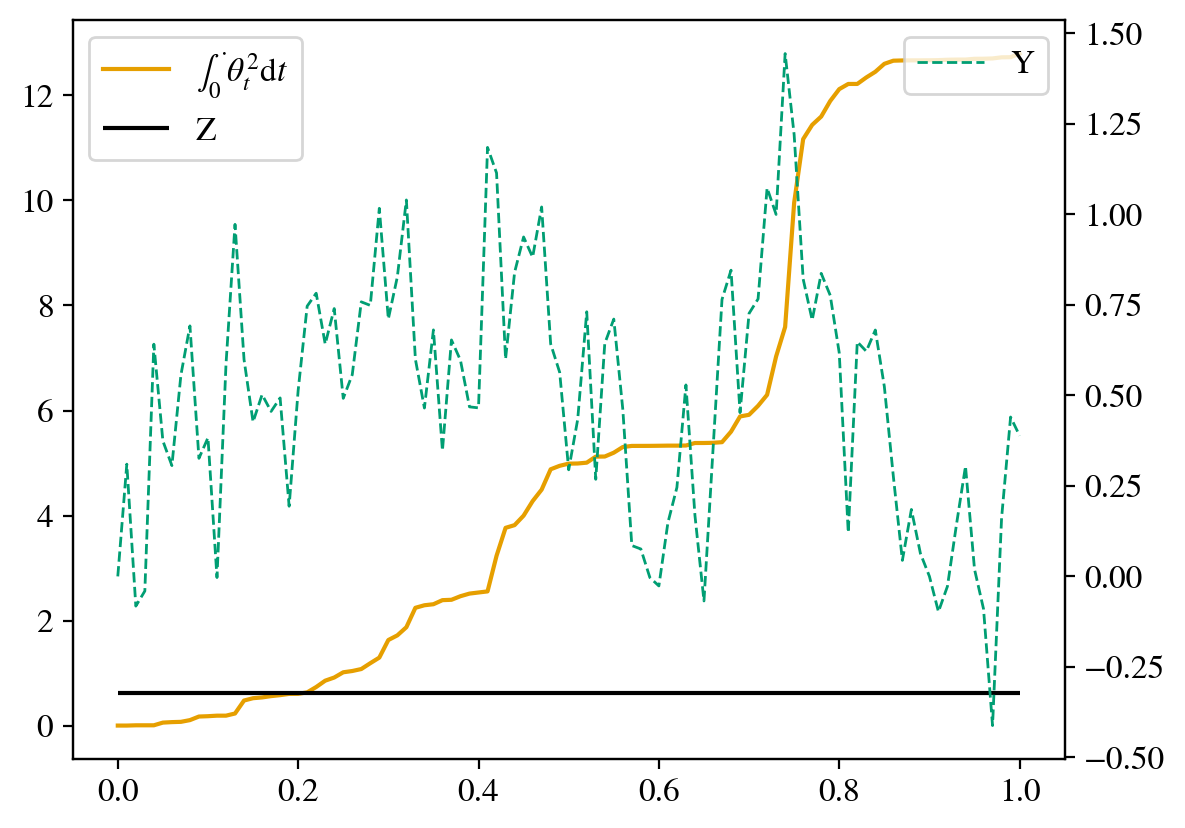

In [43]:
k = np.random.randint(batch_size)

# calculating and plotting the cumulative integral
inner_int = np.insert(np.cumsum(theta[k,:].detach().numpy()**2)*T/n, 0, 0)[:-1]
plt.plot(X[k, :, 0], inner_int, label=r"$\int_0^{\cdot} \theta_t^2 \mathrm{d}t$") 

Z = np.random.exponential(scale = 1.0)
plt.hlines(Z, 0, T, color='black', label='Z')

plt.legend();

plt.twinx() # add a new axsis since to plot the payoff
plt.plot(X[k, :, 0], Y[k,:], linewidth=1, label='Y', c="#009E73", linestyle='dashed') # plotting the underlying payoff

plt.legend();

Since we want to study different values of $H$ and the different models for the strategy more systematically, we will define the following funciton which returns a trained strategy for given model and training parameters.

In [44]:
def train_new_strategy(H, n, I, n_layers = 0, n_neurons = 0, batch_size = 1024, n_epochs = 100, learning_rate = 0.1):
    strat = DeepSignatureRule(2, I, n_layers, n_neurons)
    optimizer = torch.optim.Adam(strat.parameters(), learning_rate)
    
    for epoch in range(n_epochs):
        X = time_augmented_fbm(H, T, n, batch_size) # generating a new batch of sample paths form X
        Y = torch.from_numpy( X[:, :, 1] ) # defining the payoff
        Sig = torch.from_numpy( signature_process(X, I) ) # calculating the signature process
        theta = strat(Sig) # evaluating the linear strategy along all sample paths
    
        loss = loss_fn(theta, Y) # calculating loss
        optimizer.zero_grad() # resetting gradients
        loss.backward() # calcuating gradients
        optimizer.step() # stochastic gradient descent step
        
    return strat

Note that setting `n_layers = 0` will return a linear strategy.

**NB-Exercise 4:** *Train a deep signature strategy of your choice with the above method. Then create a plot similar to the one above, showing a sample of the trained deep strategy.*

In [58]:
# %load solutions/exercise4.py

### Performance Evaluation

To evaluate the performance of the trained signature stopping rules, we would like to compare the associated expected payoff $\mathbb{E}[Y_{\tau_\theta}]$. Higher values correspond to better performance of the stopping rule. However, we can only approximate this expected value by a Monte Carlo average.
To this end, we have two alternatives. The first alternative is to sample $Y_{\tau_\theta}$ by first sampling $\tau_\theta$ using its definition $(2)$.

**NB-Exercise 5:** *Implement a function that, for a given instance of `DeepSignatureRule` and a given number of samples `m_test`, returns a Monte Carlo average of $\mathbb{E}[Y_{\tau_\theta}]$ by first sampling $\tau_\theta$. Then check that your function provides a similar estimate as the second approach defined below.*

In [ ]:
# %load solutions/exercise5.py

The second - and simpler - approach is to use again the identity $(1)$. This allows us to give an approximation of $\mathbb{E}[Y_{\tau_\theta}]$ using our previously defined loss function. The following function implements this estimation. 
Apart from the Monte Carlo average, it also returns the **Monte Carlo error**, i.e., the sample standard deviation divided by the square root of the number of samples.

In [59]:
def estimate_value(H, n, I, strategy, m_test):
    with torch.no_grad():
        X = time_augmented_fbm(H, T, n, m_test) # generating a new batch of sample paths form X
        Y = torch.from_numpy( X[:, :, 1] ) # defining the payoff
        Sig = torch.from_numpy( signature_process(X, I) ) # calculating the signature process
        theta = strategy(Sig) # evaluating the linear strategy along all sample paths

        # Calculating the stopped value according to equation (1) (mainly copy and past from loss_fn)
        inner_integral = torch.cumsum(theta ** 2 * (T / n), axis=1)[:,:-1]
        dY = Y[:, 1:] - Y[:, :-1]
        outer_integral = torch.sum( torch.exp( - inner_integral ) * dY, axis = 1)
        values = (Y[:, 0] + outer_integral).numpy()
        
    return values.mean(), values.std()/np.sqrt(m_test)

In [60]:
strat = train_new_strategy(H=0.3, n=100, I=3, n_layers=0, n_neurons=0) # training a new linear strategy
res = estimate_value(0.3, 100, 3, strat, m_test=2**14) # evaluating its performance about 16K sample paths
print("Value: {:0.3f}, \n MC-err: {:0.5f}".format(*res))

Value: 0.234, 
 MC-err: 0.00532


### Testing Several Cases

We now want to evaluate different models of signature stopping rules for several Hurst parameters. In particular, we want to test linear strategies `n_layers = 0`, deep strategies `n_layers >= 2`, and different truncation levels `N`.
The following code will perform these tests iteratively and save the results into an HTML table. Based on the above evaluation example, we increase the number of test samples to `m_test = 2**17` to obtain more reliable estimates. Clearly, this will cost computation time, and therefore we caution to expect at least **30 minutes** of running time for the next cell.

In [61]:
mc_err = 0 # initializing the maximal Monte-Carlo error
trancations = [1, 2, 3, 4, 5] # Sequence of truncaiton levels to be tested

# setting up the table headers
html_table = f'<table border="1"><tr><td colspan=""> H </td>'
html_table += f'<td colspan="{len(trancations)}" style="text-align: center" "> linear </td>'
html_table += f'<td colspan="{len(trancations)}" style="text-align: center"> deep </td></tr>'
html_table += '<tr><td></td><td>' + "</td><td>".join(" N = {} ".format(i) for i in trancations + trancations ) + "</td></tr>"
display(HTML(html_table))

# performing all tests
for H in [0.1, 0.3, 0.5, 0.7, 0.9]:
    html_table += f'<tr><td>{H}</td>' # adding new row for a new value of H
    for n_layers in [0, 2]: # linear and deep rules
        for I in trancations:
            strat = train_new_strategy(H, 100, I, n_layers, n_neurons=30, n_epochs=200) # training a new linear or deep strategy
            res, err = estimate_value(H, 100, I, strat, m_test=2**17) # estimating expected stopping value
            mc_err = max(err, mc_err) # updating mc_error to maximum

            # adding result to the table and updating the display
            html_table += f'<td>{res:0.3f}</td>'
            clear_output()
            display(HTML(html_table))
            
    html_table += '</tr>'
html_table += '</table>'

print(f'MC-err: {mc_err:0.5f}')

KeyboardInterrupt: 

Note that the above results are a preliminary estimate of the optimal stopping values, which can be further improved by adjusting the model and learning parameters. In particular, more learning epochs and an adapted choice of the batch size would lead to better results.
Nevertheless, we can see a clear improvement when going to higher truncation levels and from linear to deep signature strategies.

Next, we would like to test how the performance depends on the size of the grid `n`. Therefore, we choose one specific model setup (`n_layers = 2`, `N = 3`) and test different grid discretizations `n = 100, 1000` for a range of Hurst parameters. Note that running the below cell takes about 15 minutes. Adding `n=10_000` to the test will increase computational time by about 30 minutes.

In [4]:
grids = [100, 1000] # add 10_000 if you have enough time to run 60min of computation
results = {n: [] for n in grids} # opening a list for results corresponding to each n
H_values = np.linspace(0.1, 1.0, 10) # range of Hurst-parameters

# setting up the table headers
html_table = f'<table border="1"><tr><td>n</td> <td colspan="10" style="text-align: center"> H </td>'
html_table += '<tr><td></td><td>' + "</td><td>".join(" {:0.1f} ".format(h) for h in H_values ) + "</td></tr>"
display(HTML(html_table))

for n in grids: 
    html_table += f'<tr><td>{n}</td>' # adding new row for a new value of n
    for H in H_values:
            strat = train_new_strategy(H, n, N = 3, n_layers = 2, n_neurons=30, batch_size=128, n_epochs=100) # training a new strategy with fixed parm.
            res, _ = estimate_value(H, n, 3, strat, m_test=2**10) # estimating expected stopping value
            results[n] += [res] # saving result in dictionarry

            # adding result to the table and updating the display
            html_table += f'<td>{res:0.3f}</td>'
            clear_output()
            display(HTML(html_table))
            
    html_table += '</tr>'
html_table += '</table>'

with open("results_table2.html", "w") as html_file:
    html_file.write(html_table)

NameError: name 'train_new_strategy' is not defined

Below we plot previously saved results that were obtained using a higher number of training epochs and test samples to reduce the amount of variance.

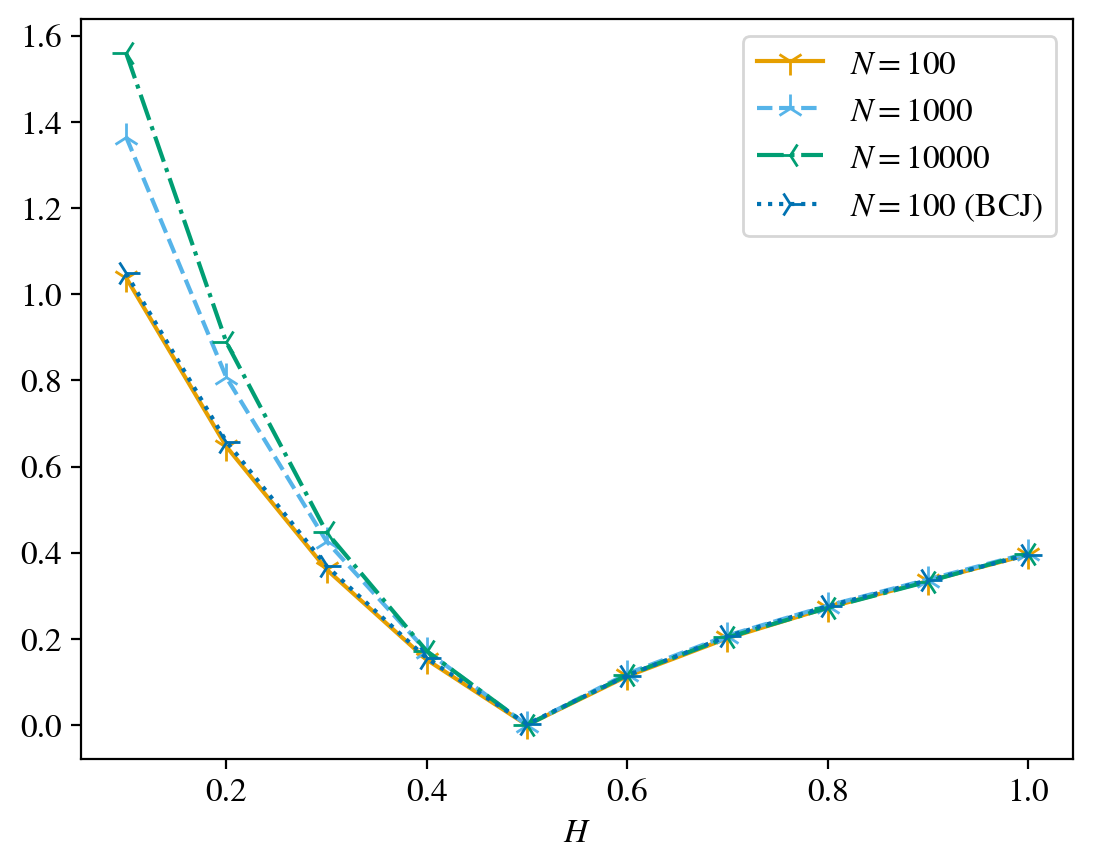

In [5]:
with open('results_grids.pkl', 'rb') as file:
    results = pickle.load(file)

plt.rc("axes", prop_cycle=line_cycler)
    
plt.plot(H_values, results[100], marker="1", markersize=10, label='$N=100$')
plt.plot(H_values, results[1000], marker="2", markersize=10, label='$N=1000$')
plt.plot(H_values, results[10_000], marker="3", markersize=10,label='$N=10000$')
plt.plot(H_values, results["BCJ"], marker="4", markersize=10,label='$N=100$ (BCJ)')
plt.xlabel('$H$')
plt.legend();
plt.savefig("grids.pdf")

## Longstaff–Schwartz approach

We are next going to implement the *signature Longstaff–Schwartz* method for approximation the value of Bermudan option with $N$ equidistant exercise opportinities $0 = t_0 < t_1 < \dots < t_N = T$. Recall that this approach bases on the dynamic programming principle which allows the following recursive definition for the optimal stopping time $\tau_n \ge t_n$:
$$\tau_N = T, \qquad \tau_n :=
  \begin{cases}
    t_n, & Y_{t_n} \ge \mathbb{E}\left[ Y_{\tau_{n+1}} \mid \mathcal{F}_{t_n} \right],\\
    \tau_{n+1}, & \text{else}, \quad
\end{cases} \qquad \text{for } n = N-1, N-2, \dots, 0.$$
Assuming that the fitration is generated by the underyling path, here $Y = X$ the fraction Brownian motion, the conditional expectation must have the functional representaitons $\mathbb{E}\left[ Y_{\tau_{n+1}} \mid \mathcal{F}_{t_n} \right] = f_{t_n}(X\vert_{[0,t_n]})$.
The signature ansatz consists in learning the functionals $f_n$ as linear linear functionals of the signature of the time augmented path ${\widehat{\mathbb{X}}}^{\le I}_{0,t_n}$. 
To this end, we use a least-squares regression approach and find the linear functional $\ell_n \in T(\mathbb{R}^d)^{\le I}$ that minizies a Monte-Carlo avarage of
$$
   \mathbb{E}\left[ \left( Y_{\tau_{n+1}} - \langle \ell, \, \widehat{\mathbb{X}}^{\le I}_{0,t_n} \rangle \right)^2 \right] \quad\longrightarrow\quad \min_{\ell \in T(\mathbb{R}^d)^{\le I}}.
$$
